In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mason_functions as mf
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import acquireTelco
import prepareTelco

## Data Wrangle

In [2]:
#acquire data from database
df = acquireTelco.get_telco_data()

In [3]:
#check out data info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [4]:
#at a glance
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [5]:
#total_charges column holds object type values. I need these to be numeric values
df.total_charges = df.total_charges.str.strip()
df = df[df.total_charges != '']
df.total_charges = df.total_charges.astype(float)

In [6]:
#confirm my total_charges holds float64 data types
df.total_charges.dtype

dtype('float64')

In [7]:
#customer_id is not a useful feature, but it should serve as an index
df = df.set_index('customer_id')

In [8]:
#payment_type_id, internet_service_type_id and contract_type_id are all redundant 
df = df.drop(columns = ['payment_type_id', 'internet_service_type_id', 'contract_type_id'])

In [9]:
#what are my categorical values?
df.nunique()

gender                      2
senior_citizen              2
partner                     2
dependents                  2
tenure                     72
phone_service               2
multiple_lines              3
online_security             3
online_backup               3
device_protection           3
tech_support                3
streaming_tv                3
streaming_movies            3
paperless_billing           2
monthly_charges          1584
total_charges            6530
churn                       2
contract_type               3
internet_service_type       3
payment_type                4
dtype: int64

In [10]:
df.churn.value_counts()

No     5163
Yes    1869
Name: churn, dtype: int64

In [11]:
df.multiple_lines.value_counts()
df.tech_support.value_counts()

No                     3472
Yes                    2040
No internet service    1520
Name: tech_support, dtype: int64

In [12]:
#now I want to one-hot encode my categorical variables for later exploration
df = df.replace('No', 0).replace('Yes', 1)

In [13]:
df.sample(4)

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
customer_id,,,,,,,,,,,,,,,,,,,,
9199-PWQVC,Female,0,1,0,63,1,1,1,1,0,0,1,1,1,79.70,4786.15,0,One year,DSL,Credit card (automatic)
2101-RANCD,Female,0,0,0,55,1,1,0,0,0,0,0,0,1,73.10,4144.90,0,Month-to-month,Fiber optic,Electronic check
4667-OHGKG,Male,0,0,0,1,1,0,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,1,19.30,19.30,1,Month-to-month,None,Mailed check
1271-UODNO,Male,0,0,0,39,1,1,0,0,0,1,0,0,1,53.85,2200.70,0,Two year,DSL,Credit card (automatic)


In [14]:
#one-hot encode gender
dummy_1 = pd.get_dummies(df['gender'], dummy_na = False, drop_first = True)

In [15]:
dummy_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Male    7032 non-null   uint8
dtypes: uint8(1)
memory usage: 61.8+ KB


In [16]:
#rename gender column
dummy_1.columns = dummy_1.columns.str.replace('Male', 'is_male')

In [17]:
dummy_1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   is_male  7032 non-null   uint8
dtypes: uint8(1)
memory usage: 61.8+ KB


In [18]:
#more one-hot encoding (get dummy variables for categorical columns with more than 2 unique values)
#I don't drop the first because I'm picky on categorical columns with more than 2 unique values
categ_col = df.columns[df.nunique() > 2].to_list()
dummy_2 = pd.get_dummies(df[categ_col], dummy_na = False, drop_first = False)

In [19]:
#make sure my dummy dataframe looks good
dummy_2.head()

,tenure,monthly_charges,total_charges,multiple_lines_0,multiple_lines_1,multiple_lines_No phone service,online_security_0,online_security_1,online_security_No internet service,online_backup_0,...,contract_type_Month-to-month,contract_type_One year,contract_type_Two year,internet_service_type_DSL,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Bank transfer (automatic),payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
customer_id,,,,,,,,,,,,,,,,,,,,,
0016-QLJIS,65,90.45,5957.90,0,1,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,1
0017-DINOC,54,45.20,2460.55,0,0,1,0,1,0,1,...,0,0,1,1,0,0,0,1,0,0
0019-GFNTW,56,45.05,2560.10,0,0,1,0,1,0,0,...,0,0,1,1,0,0,1,0,0,0
0056-EPFBG,20,39.40,825.40,0,0,1,0,1,0,1,...,0,0,1,1,0,0,0,1,0,0
0078-XZMHT,72,85.15,6316.20,0,1,0,1,0,0,0,...,0,0,1,1,0,0,1,0,0,0


In [20]:
#summary view
dummy_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   tenure                                  7032 non-null   int64  
 1   monthly_charges                         7032 non-null   float64
 2   total_charges                           7032 non-null   float64
 3   multiple_lines_0                        7032 non-null   uint8  
 4   multiple_lines_1                        7032 non-null   uint8  
 5   multiple_lines_No phone service         7032 non-null   uint8  
 6   online_security_0                       7032 non-null   uint8  
 7   online_security_1                       7032 non-null   uint8  
 8   online_security_No internet service     7032 non-null   uint8  
 9   online_backup_0                         7032 non-null   uint8  
 10  online_backup_1                         7032 non-n

In [21]:
#clean up column names
dummy_2.columns = dummy_2.columns.str.lower().str.replace(' ', '_').str.replace('_1', '').str.replace('_type', '').str.replace('no_internet_service', 'no_internet')

In [22]:
#What does it look like now?
dummy_2.head()

,tenure,monthly_charges,total_charges,multiple_lines_0,multiple_lines,multiple_lines_no_phone_service,online_security_0,online_security,online_security_no_internet,online_backup_0,...,contract_month-to-month,contract_one_year,contract_two_year,internet_service_dsl,internet_service_fiber_optic,internet_service_none,payment_bank_transfer_(automatic),payment_credit_card_(automatic),payment_electronic_check,payment_mailed_check
customer_id,,,,,,,,,,,,,,,,,,,,,
0016-QLJIS,65,90.45,5957.90,0,1,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,1
0017-DINOC,54,45.20,2460.55,0,0,1,0,1,0,1,...,0,0,1,1,0,0,0,1,0,0
0019-GFNTW,56,45.05,2560.10,0,0,1,0,1,0,0,...,0,0,1,1,0,0,1,0,0,0
0056-EPFBG,20,39.40,825.40,0,0,1,0,1,0,1,...,0,0,1,1,0,0,0,1,0,0
0078-XZMHT,72,85.15,6316.20,0,1,0,1,0,0,0,...,0,0,1,1,0,0,1,0,0,0


In [23]:
#I do not want these first dummy columns
dummy_drop = dummy_2.columns[dummy_2.columns.str.contains('_0')].to_list()
dummy_drop_again = dummy_2.columns[dummy_2.columns.str.contains('_no_')].to_list()
dummy_drop.extend(dummy_drop_again)
dummy_2 = dummy_2.drop(columns = dummy_drop)

In [24]:
#how are we doing so far?
dummy_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 20 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   tenure                             7032 non-null   int64  
 1   monthly_charges                    7032 non-null   float64
 2   total_charges                      7032 non-null   float64
 3   multiple_lines                     7032 non-null   uint8  
 4   online_security                    7032 non-null   uint8  
 5   online_backup                      7032 non-null   uint8  
 6   device_protection                  7032 non-null   uint8  
 7   tech_support                       7032 non-null   uint8  
 8   streaming_tv                       7032 non-null   uint8  
 9   streaming_movies                   7032 non-null   uint8  
 10  contract_month-to-month            7032 non-null   uint8  
 11  contract_one_year                  7032 non-nu

In [25]:
#preview
dummy_2.head()

,tenure,monthly_charges,total_charges,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,contract_month-to-month,contract_one_year,contract_two_year,internet_service_dsl,internet_service_fiber_optic,internet_service_none,payment_bank_transfer_(automatic),payment_credit_card_(automatic),payment_electronic_check,payment_mailed_check
customer_id,,,,,,,,,,,,,,,,,,,,
0016-QLJIS,65,90.45,5957.90,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,1
0017-DINOC,54,45.20,2460.55,0,1,0,0,1,1,0,0,0,1,1,0,0,0,1,0,0
0019-GFNTW,56,45.05,2560.10,0,1,1,1,1,0,0,0,0,1,1,0,0,1,0,0,0
0056-EPFBG,20,39.40,825.40,0,1,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0
0078-XZMHT,72,85.15,6316.20,1,0,1,1,1,1,1,0,0,1,1,0,0,1,0,0,0


In [26]:
#I want easier column names
dummy_2 = dummy_2.rename(columns = {
    'contract_month-to-month': 'm2m_contract',
    'contract_one_year': 'one_year_contract',
    'contract_two_year': 'two_year_contract',
    'internet_service_dsl': 'DSL_internet',
    'internet_service_fiber_optic': 'Fiber_internet',
    'internet_service_none': 'no_internet',
    'payment_bank_transfer_(automatic)': 'bank_auto_payment',
    'payment_credit_card_(automatic)': 'card_auto_payment',
    'payment_electronic_check': 'electronic_check_payment',
    'payment_mailed_check': 'mailed_check_payment'
})

In [27]:
#check column names
dummy_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   tenure                    7032 non-null   int64  
 1   monthly_charges           7032 non-null   float64
 2   total_charges             7032 non-null   float64
 3   multiple_lines            7032 non-null   uint8  
 4   online_security           7032 non-null   uint8  
 5   online_backup             7032 non-null   uint8  
 6   device_protection         7032 non-null   uint8  
 7   tech_support              7032 non-null   uint8  
 8   streaming_tv              7032 non-null   uint8  
 9   streaming_movies          7032 non-null   uint8  
 10  m2m_contract              7032 non-null   uint8  
 11  one_year_contract         7032 non-null   uint8  
 12  two_year_contract         7032 non-null   uint8  
 13  DSL_internet              7032 non-null   uint8  
 14

In [28]:
#drop dummied categorical columns from original df
df = df.drop(columns = categ_col)
df = df.drop(columns = 'gender')

In [29]:
#check out original df
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   senior_citizen     7032 non-null   int64
 1   partner            7032 non-null   int64
 2   dependents         7032 non-null   int64
 3   phone_service      7032 non-null   int64
 4   paperless_billing  7032 non-null   int64
 5   churn              7032 non-null   int64
dtypes: int64(6)
memory usage: 384.6+ KB


In [30]:
#concatenate resulting dataframes
telco = pd.concat([dummy_1, df, dummy_2], axis = 1)

In [31]:
#preview
telco.head()

,is_male,senior_citizen,partner,dependents,phone_service,paperless_billing,churn,tenure,monthly_charges,total_charges,...,m2m_contract,one_year_contract,two_year_contract,DSL_internet,Fiber_internet,no_internet,bank_auto_payment,card_auto_payment,electronic_check_payment,mailed_check_payment
customer_id,,,,,,,,,,,,,,,,,,,,,
0016-QLJIS,0,0,1,1,1,1,0,65,90.45,5957.90,...,0,0,1,1,0,0,0,0,0,1
0017-DINOC,1,0,0,0,0,0,0,54,45.20,2460.55,...,0,0,1,1,0,0,0,1,0,0
0019-GFNTW,0,0,0,0,0,0,0,56,45.05,2560.10,...,0,0,1,1,0,0,1,0,0,0
0056-EPFBG,1,0,1,1,0,1,0,20,39.40,825.40,...,0,0,1,1,0,0,0,1,0,0
0078-XZMHT,1,0,1,0,1,1,0,72,85.15,6316.20,...,0,0,1,1,0,0,1,0,0,0


In [32]:
#check out end result
telco.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0016-QLJIS to 9986-BONCE
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   is_male                   7032 non-null   uint8  
 1   senior_citizen            7032 non-null   int64  
 2   partner                   7032 non-null   int64  
 3   dependents                7032 non-null   int64  
 4   phone_service             7032 non-null   int64  
 5   paperless_billing         7032 non-null   int64  
 6   churn                     7032 non-null   int64  
 7   tenure                    7032 non-null   int64  
 8   monthly_charges           7032 non-null   float64
 9   total_charges             7032 non-null   float64
 10  multiple_lines            7032 non-null   uint8  
 11  online_security           7032 non-null   uint8  
 12  online_backup             7032 non-null   uint8  
 13  device_protection         7032 non-null   uint8  
 14

In [33]:
def prep_telco():
    
    #acquire data from database
    df = acquireTelco.get_telco_data()
    
    #total_charges column holds object type values. I need these to be numeric values
    df.total_charges = df.total_charges.str.strip()
    df = df[df.total_charges != '']
    df.total_charges = df.total_charges.astype(float)
    
    #customer_id is not a useful feature, but it should serve as an index
    df = df.set_index('customer_id')
    
    #payment_type_id, internet_service_type_id and contract_type_id are all redundant 
    df = df.drop(columns = ['payment_type_id', 'internet_service_type_id', 'contract_type_id'])
    
    #now I want to one-hot encode my categorical variables for later exploration
    df = df.replace('No', 0).replace('Yes', 1)
    
    #one-hot encode gender
    dummy_1 = pd.get_dummies(df['gender'], dummy_na = False, drop_first = True)
    
    #rename column
    dummy_1.columns = dummy_1.columns.str.replace('Male', 'is_male')
    
    #more one-hot encoding (get dummy variables for categorical columns with more than 2 unique values)
    #I don't drop the first because I'm picky on categorical columns with more than 2 unique values
    categ_col = df.columns[df.nunique() > 2].to_list()
    dummy_2 = pd.get_dummies(df[categ_col], dummy_na = False, drop_first = False)
    
    #clean up column names
    dummy_2.columns = dummy_2.columns.str.lower().str.replace(' ', '_').str.replace('_1', '').str.replace('_type', '').str.replace('no_internet_service', 'no_internet')
    
    #I do not want these particular first dummy columns
    dummy_drop = dummy_2.columns[dummy_2.columns.str.contains('_0')].to_list()
    dummy_drop_again = dummy_2.columns[dummy_2.columns.str.contains('_no_')].to_list()
    dummy_drop.extend(dummy_drop_again)
    dummy_2 = dummy_2.drop(columns = dummy_drop)
    
    #I want easier column names to work with
    dummy_2 = dummy_2.rename(columns = {
        'contract_month-to-month': 'm2m_contract',
        'contract_one_year': 'one_year_contract',
        'contract_two_year': 'two_year_contract',
        'internet_service_dsl': 'DSL_internet',
        'internet_service_fiber_optic': 'Fiber_internet',
        'internet_service_none': 'no_internet',
        'payment_bank_transfer_(automatic)': 'bank_auto_payment',
        'payment_credit_card_(automatic)': 'card_auto_payment',
        'payment_electronic_check': 'electronic_check_payment',
        'payment_mailed_check': 'mailed_check_payment'
    })
    
    #drop dummied categorical columns 
    df = df.drop(columns = categ_col)
    df = df.drop(columns = 'gender')
    
    #concatenate the dataframes
    telco = pd.concat([dummy_1, df, dummy_2], axis = 1)
    
    #return the resulting dataframe
    return telco

In [34]:
#load the prepped data
train, validate, test = prepareTelco.prep_telco_data()

In [35]:
#everything looks ok
train.sample(2)

,is_male,senior_citizen,partner,dependents,phone_service,paperless_billing,churn,tenure,monthly_charges,total_charges,...,m2m_contract,one_year_contract,two_year_contract,DSL_internet,Fiber_internet,no_internet,bank_auto_payment,card_auto_payment,electronic_check_payment,mailed_check_payment
customer_id,,,,,,,,,,,,,,,,,,,,,
8606-OEGQZ,0,0,0,1,1,0,0,18,25.3,454.65,...,0,0,1,0,0,1,0,1,0,0
3194-ORPIK,0,0,1,1,1,1,1,50,84.4,4116.15,...,1,0,0,0,1,0,1,0,0,0


In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3937 entries, 4566-NECEV to 5816-JMLGY
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   is_male                   3937 non-null   uint8  
 1   senior_citizen            3937 non-null   int64  
 2   partner                   3937 non-null   int64  
 3   dependents                3937 non-null   int64  
 4   phone_service             3937 non-null   int64  
 5   paperless_billing         3937 non-null   int64  
 6   churn                     3937 non-null   int64  
 7   tenure                    3937 non-null   int64  
 8   monthly_charges           3937 non-null   float64
 9   total_charges             3937 non-null   float64
 10  multiple_lines            3937 non-null   uint8  
 11  online_security           3937 non-null   uint8  
 12  online_backup             3937 non-null   uint8  
 13  device_protection         3937 non-null   uint8  
 14

In [37]:
#everything checks out
train.shape, validate.shape, test.shape

((3937, 27), (1688, 27), (1407, 27))

## Explore Univariate Stats

In [38]:
#define my target, categorical columns and numeric columns
target = 'churn'
cat_vars = telco.columns[telco.nunique() == 2].to_list()
cat_vars.remove(target)
quant_vars = telco.columns[telco.nunique() > 2].to_list()

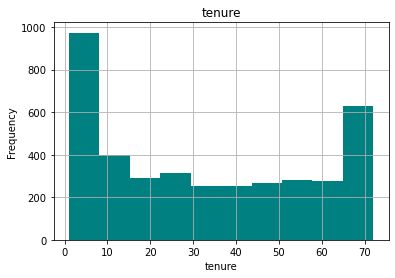

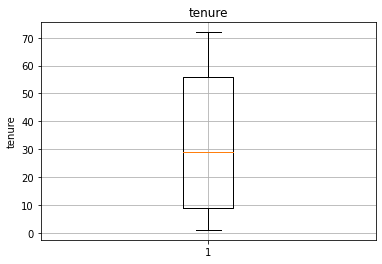

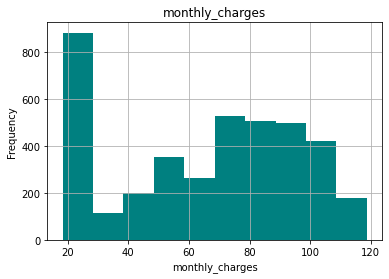

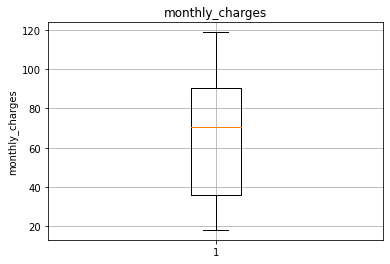

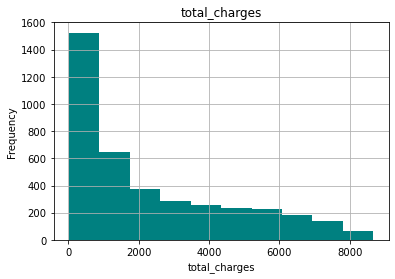

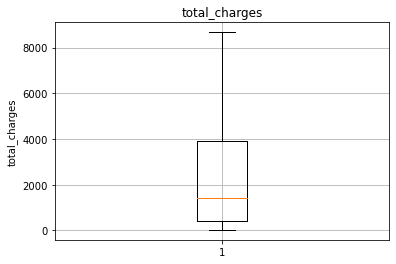

In [39]:
#distributions for numeric variables
for cat in quant_vars:
    train[cat].hist(color = 'teal')
    plt.title(cat)
    plt.xlabel(cat)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show();
    plt.boxplot(train[cat])
    plt.title(cat)
    plt.ylabel(cat)
    plt.grid(True)
    plt.show();

0    2891
1    1046
Name: churn, dtype: int64
---------------------------
0    0.734315
1    0.265685
Name: churn, dtype: float64
---------------------------
27% of customers churn overall.


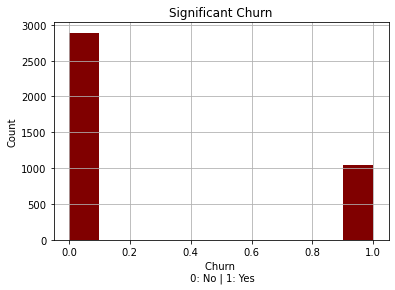

In [40]:
#Target visualization (proportion of churn)
train.churn.hist(color = 'maroon')
plt.title('Significant Churn')
plt.xlabel('Churn \n 0: No | 1: Yes')
plt.ylabel('Count');
print(train.churn.value_counts())
print('---------------------------')
print(train.churn.value_counts(normalize = True))
print('---------------------------')
print(f'{round(train.churn.mean() * 100)}% of customers churn overall.')

In [41]:
#descriptive statistics
train[quant_vars].describe().T

,count,mean,std,min,25%,50%,75%,max
tenure,3937.0,32.628651,24.597115,1.00,9.00,29.00,56.00,72.00
monthly_charges,3937.0,65.065189,30.101776,18.25,35.75,70.40,90.15,118.75
total_charges,3937.0,2319.589929,2296.673813,18.80,402.60,1410.25,3923.80,8672.45


In [42]:
train.churn.value_counts()

0    2891
1    1046
Name: churn, dtype: int64

### Question 1
What percentage of customers are churning overall? For the 1 year plan? The 2 year plan? The month-to-month plan?

In [43]:
#assign variables to respective data
one_year = train[train.one_year_contract == 1]
two_year = train[train.two_year_contract == 1]
m2m = train[train.m2m_contract == 1]

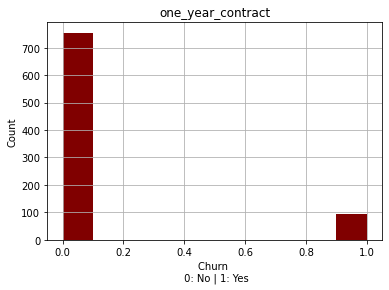

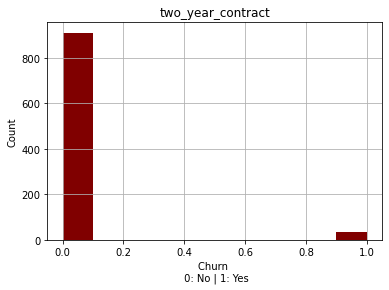

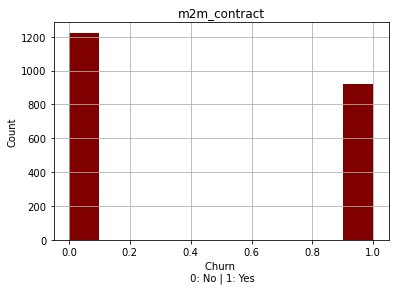

In [44]:
#show churn for contract types
contract_type = ['one_year_contract', 'two_year_contract', 'm2m_contract']
for contract in contract_type:
    train[train[contract] == 1].churn.hist(color = 'maroon')
    plt.title(contract)
    plt.xlabel('Churn \n 0: No | 1: Yes')
    plt.ylabel('Count')
    plt.show();

27% of overall customers churn.
11% of customers with a 1 year contract churn.
3% of customers with a 2 year contract churn.
43% of customers on the month-to-month contract churn.


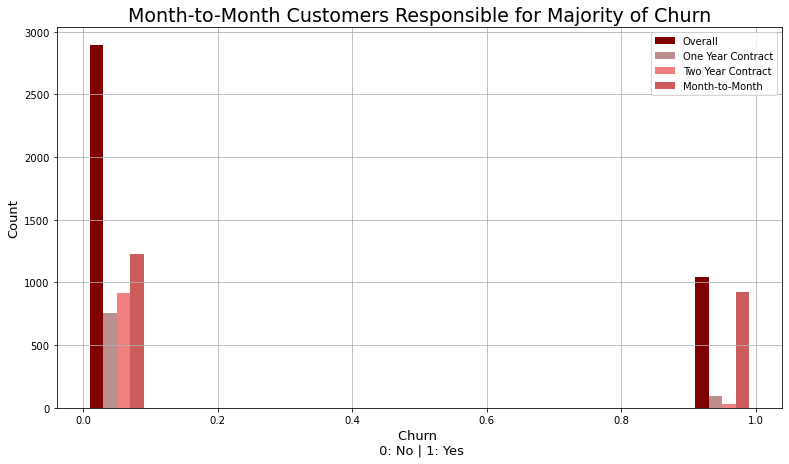

In [45]:
#direct comparison
plt.figure(figsize = (13, 7))
plt.hist([train.churn, one_year.churn, two_year.churn, m2m.churn],
         label = ['Overall', 'One Year Contract', 'Two Year Contract', 'Month-to-Month'],
         color = ['maroon', 'rosybrown', 'lightcoral', 'indianred']
        )
plt.grid(True)
plt.legend()
plt.title('Month-to-Month Customers Responsible for Majority of Churn', size = 19)
plt.xlabel('Churn \n 0: No | 1: Yes', size = 13)
plt.ylabel('Count', size = 13);

#find percentage of churn across contracts
print(f'{round(train.churn.mean() * 100)}% of overall customers churn.')
print(f'{round(one_year.churn.mean() * 100)}% of customers with a 1 year contract churn.')
print(f'{round(two_year.churn.mean() * 100)}% of customers with a 2 year contract churn.')
print(f'{round(m2m.churn.mean() * 100)}% of customers on the month-to-month contract churn.')

### Takeaways
* over a quarter of customers are churning

* customers on the month-to-month contract churn far more than customers on other contracts

### Question 2
A. Do churned customers have higher average charges than retained customers? 

B. Are higher charges associated with churn?

Question A. 

Do customers who churn have higher average charges than retained customers? 

In [46]:
#assign variables to respective data
churned = train[train.churn == 1]
retained = train[train.churn == 0]

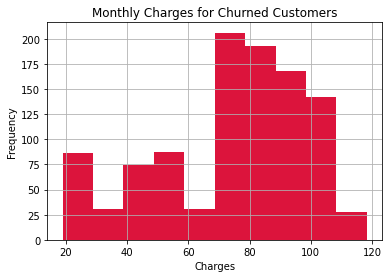

In [47]:
#chart churned monthly charges
churned.monthly_charges.hist(color = 'crimson')
plt.title('Monthly Charges for Churned Customers')
plt.xlabel('Charges')
plt.ylabel('Frequency');

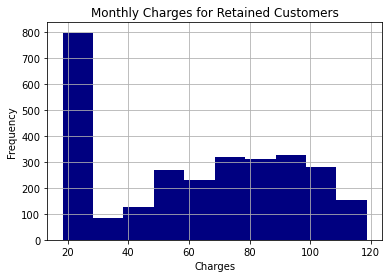

In [48]:
#chart retained monthly charges
retained.monthly_charges.hist(color = 'navy')
plt.title('Monthly Charges for Retained Customers')
plt.xlabel('Charges')
plt.ylabel('Frequency');

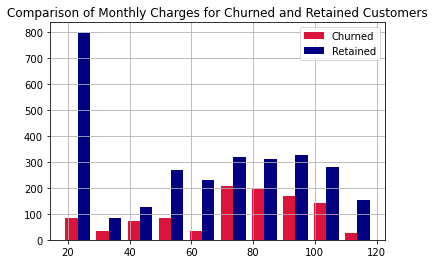

In [49]:
#Direct comparison
plt.hist([churned.monthly_charges, retained.monthly_charges],
    label = ['Churned', 'Retained'],
    color = ['crimson', 'navy']
    )
plt.grid(True)
plt.legend()
plt.title('Comparison of Monthly Charges for Churned and Retained Customers');

#### Null hypothesis: Customers who churn are charged the same or less as customers who do not churn.

#### Alternate hypothesis: Customers who churn are charged more than customers who do not.

In [50]:
#variances at a glance
churned.monthly_charges.var(), retained.monthly_charges.var()

(609.6802277644607, 977.3193572661372)

In [51]:
#just to be sure these are way different variances (low p value indicates so)
stats.levene(churned.monthly_charges, retained.monthly_charges)

LeveneResult(statistic=193.92634874338017, pvalue=4.576508698032445e-43)

In [52]:
#test for normality
stats.normaltest(retained.monthly_charges)

NormaltestResult(statistic=64272.884213975194, pvalue=0.0)

In [53]:
#test for normality
stats.normaltest(churned.monthly_charges)

NormaltestResult(statistic=78.9748116479764, pvalue=7.093123899369489e-18)

In [54]:
#how many observations
print(len(churned))
print(len(retained))

1046
2891


We have enough observations and the distributions seem normal enough (normality), but the normality test says they are not normal, and the variances are not equal, but the observations are independent of each other.

In [55]:
#use Mann-Whitney U test 
stats.mannwhitneyu(churned.monthly_charges, retained.monthly_charges, alternative = 'greater')

MannwhitneyuResult(statistic=1831827.0, pvalue=1.6091212849297898e-24)

In [56]:
#ttest_ind
stats.ttest_ind(churned.monthly_charges, retained.monthly_charges, equal_var = False, alternative = 'greater')

Ttest_indResult(statistic=12.178218374409106, pvalue=2.023360253234964e-33)

#### The extremely low p-value indicates that we can confidently reject the null hypothesis that customers who churn are charged less or the same as retained customers.

#### Takeaways
* customers who churn are charged significantly more than those who do not

Question B.

Are higher charges associated with churn?

In [57]:
#the average monthly charge is $65 and the upper quartile cutoff is at $90 (from descriptive statistics)
train['high_charges'] = train.monthly_charges > 90
train['higher_than_average_charges'] = train.monthly_charges >= 66
high_charges = train[train.monthly_charges > 90]
higher_than_average_charges = train[train.monthly_charges >= 66]

In [58]:
#looks good
train.high_charges.head()

customer_id
4566-NECEV     True
2640-LYMOV    False
6496-SLWHQ     True
7216-EWTRS     True
8887-IPQNC    False
Name: high_charges, dtype: bool

In [59]:
#number of observations
print('Observations')
print(len(higher_than_average_charges))
print(len(high_charges))

Observations
2173
999


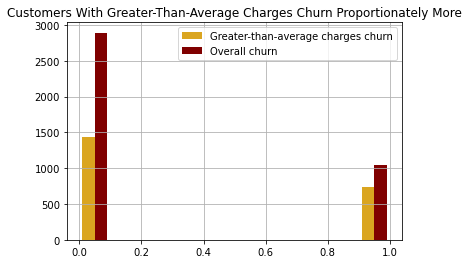

In [60]:
#Juxtaposition of churn between customers with greater-than-average charges and the overall population
plt.hist([higher_than_average_charges.churn, train.churn],
         label = ['Greater-than-average charges churn', 'Overall churn'],
         color = ['goldenrod', 'maroon']
        )
plt.title('Customers With Greater-Than-Average Charges Churn Proportionately More')
plt.grid(True)
plt.legend();

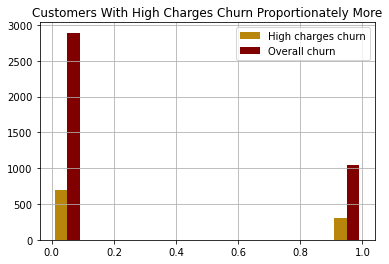

In [61]:
#Juxtaposition of churn between customers with higher charges and the overall population
plt.hist([high_charges.churn, train.churn],
         label = ['High charges churn', 'Overall churn'],
         color = ['darkgoldenrod', 'maroon']
        )
plt.title('Customers With High Charges Churn Proportionately More')
plt.grid(True)
plt.legend();

#### Null hypothesis: High charges and churn are independent of each other.
#### Alternate hypothesis: High charges are associated with churn.

In [62]:
#crosstab of high charges and churn
observed = pd.crosstab(train.high_charges, train.churn)
observed

churn,0,1
high_charges,,
False,2198,740
True,693,306


In [63]:
#results
chi2, p, degf, expected = stats.chi2_contingency(observed)
print('Observed')
print('--------')
print(observed.values)
print('===================')
print('Expected')
print('--------')
print(expected.astype(int))
print('===================')
print(f'Degrees of Freedom: {degf}')
print('===================')
print('Chi^2 and P')
print('-----------')
print(f'chi^2 = {chi2:.4f}')
print(f'p = {p:.4f}')

Observed
--------
[[2198  740]
 [ 693  306]]
Expected
--------
[[2157  780]
 [ 733  265]]
Degrees of Freedom: 1
Chi^2 and P
-----------
chi^2 = 11.0454
p = 0.0009


#### Extremely low p-value indicates that I can reject the null hypothesis that high charges and churn are independent of each other

What about greater-than-average charges?

#### Null hypothesis: Greater-than-average charges and churn are independent of each other.
#### Alternate hypothesis: Greater-than-average charges are associated with churn.

In [64]:
#crosstab of higher than average charges and churn
observed = pd.crosstab(train.higher_than_average_charges, train.churn)
observed

churn,0,1
higher_than_average_charges,,
False,1460,304
True,1431,742


In [65]:
#results
chi2, p, degf, expected = stats.chi2_contingency(observed)
print('Observed')
print('--------')
print(observed.values)
print('===================')
print('Expected')
print('--------')
print(expected.astype(int))
print('===================')
print(f'Degrees of Freedom: {degf}')
print('===================')
print('Chi^2 and P')
print('-----------')
print(f'chi^2 = {chi2:.4f}')
print(f'p = {p:.4f}')

Observed
--------
[[1460  304]
 [1431  742]]
Expected
--------
[[1295  468]
 [1595  577]]
Degrees of Freedom: 1
Chi^2 and P
-----------
chi^2 = 141.8837
p = 0.0000


#### Extremely low p-value indicates that I can reject the null hypothesis that greater-than-average charges and churn are independent of each other

#### Takeaways
* higher charges are associated with churn
* this may be a useful feature; I will create this feature on my train and validate sets

In [66]:
#follow through on feature creation
validate['high_charges'] = train.monthly_charges > 90
validate['higher_than_average_charges'] = train.monthly_charges >= 66
test['high_charges'] = train.monthly_charges > 90
test['higher_than_average_charges'] = train.monthly_charges >= 66

### Question 3
What is the churn rate for male customers vs female customers?

In [67]:
#assign variables to respective data
male = train[train.is_male == 1]
female = train[train.is_male == 0]

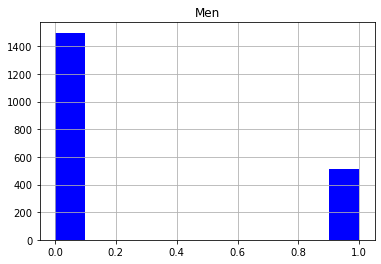

In [68]:
#show churn for men
plt.title('Men')
male.churn.hist(color = 'blue');

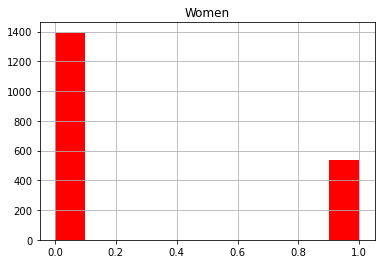

In [69]:
#show churn for women
plt.title('Women')
female.churn.hist(color = 'red');

25% of customers who churn are men.
28% of customers who churn are women.


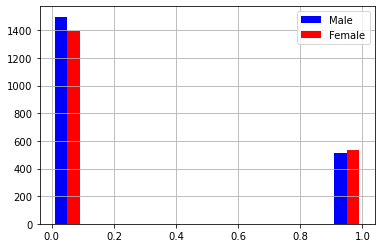

In [70]:
#comparison view
plt.hist([male.churn, female.churn],
    label = ['Male', 'Female'],
    color = ['blue', 'red']
    )
plt.grid(True)
plt.legend();

#compare churn rates across gender
print(f'{round(male.churn.mean() * 100)}% of customers who churn are men.')
print(f'{round(female.churn.mean() * 100)}% of customers who churn are women.')

#### Takeaways
* churn rate for male customers and female customers seem the same

### Question 4
What is the rate of churn for customers with dependents vs customers without?

In [71]:
#assign variables to relevant data
has_dependents = train[train.dependents == 1]
no_dependents = train[train.dependents == 0]

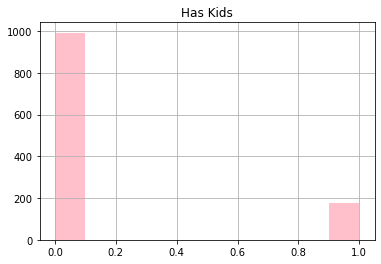

In [72]:
#show churn for customers with dependents
plt.title('Has Kids')
has_dependents.churn.hist(color = 'pink');

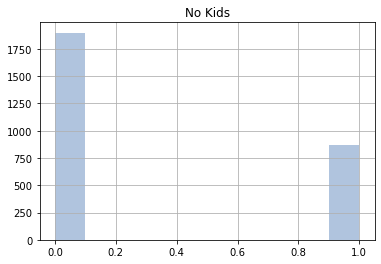

In [73]:
#show churn for customers without dependents
plt.title('No Kids')
no_dependents.churn.hist(color = 'lightsteelblue');

15% of customers with dependents churn.
31% of customers without dependents churn.


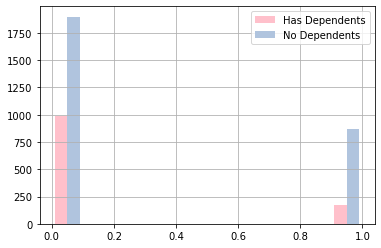

In [74]:
#comparison view
plt.hist([has_dependents.churn, no_dependents.churn],
         label = ['Has Dependents', 'No Dependents'],
         color = ['pink', 'lightsteelblue']
        )
plt.grid(True)
plt.legend();

#compare churn across status on dependent claim
print(f'{round(has_dependents.churn.mean() * 100)}% of customers with dependents churn.')
print(f'{round(no_dependents.churn.mean() * 100)}% of customers without dependents churn.')

#### Takeaways
 * customers without dependents seem to churn more than those without

### Question 5
Is there any difference in churn rate for customers with a partner vs customers without?

In [75]:
#assign variables to respective data
has_partner = train[train.partner == 1]
no_partner = train[train.partner == 0]

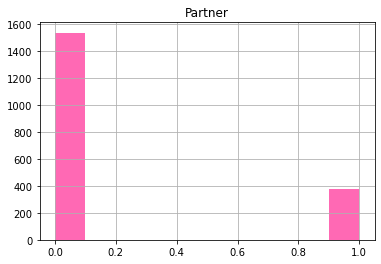

In [76]:
#show churn for customers with partner
plt.title('Partner')
has_partner.churn.hist(color = 'hotpink');

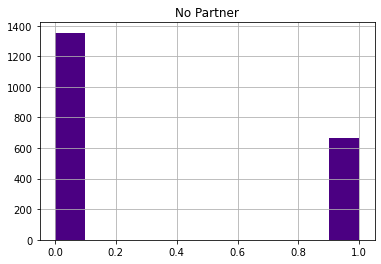

In [77]:
#show churn for customers without a partner
plt.title('No Partner')
no_partner.churn.hist(color = 'indigo');

20% of customers with a partner churn.
33% of customers without a partner churn.


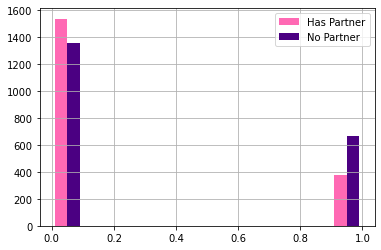

In [78]:
#comparison view
plt.hist([has_partner.churn, no_partner.churn],
         color = ['hotpink', 'indigo'],
         label = ['Has Partner', 'No Partner']
        )
plt.legend()
plt.grid(True);

#compare churn rates across partner status
print(f'{round(has_partner.churn.mean() * 100)}% of customers with a partner churn.')
print(f'{round(no_partner.churn.mean() * 100)}% of customers without a partner churn.')

#### Takeaways
* customers without a partner seem to churn much more

### Question 6
Do customers with a streaming movie or streaming tv service churn more than those who do not have these services?

In [79]:
#assign variables to respective data
has_movies = train[train.streaming_movies == 1]
no_movies = train[train.streaming_movies == 0]
has_stream = train[train.streaming_tv == 1]
no_stream = train[train.streaming_tv == 0]

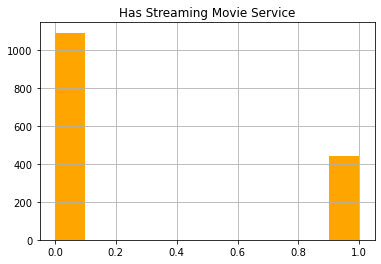

In [80]:
#show churn for customers with movies
plt.title('Has Streaming Movie Service')
has_movies.churn.hist(color = 'orange');

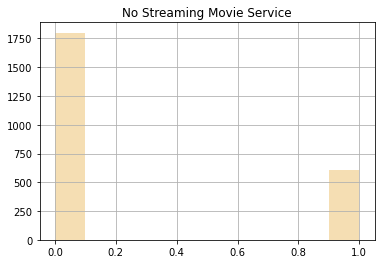

In [81]:
#show churn for customers without movies
plt.title('No Streaming Movie Service')
no_movies.churn.hist(color = 'wheat');

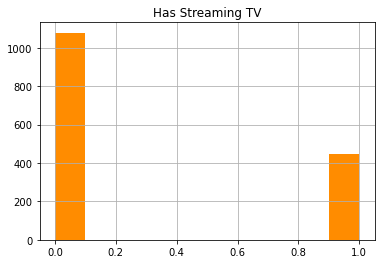

In [82]:
#show churn for customers with streaming tv
plt.title('Has Streaming TV')
has_stream.churn.hist(color = 'darkorange');

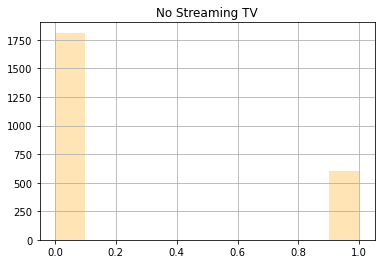

In [83]:
#show churn for customers without streaming tv
plt.title('No Streaming TV')
no_stream.churn.hist(color = 'moccasin');

29% of customers with the streaming movie service churn.
25% of customers without the streaming movie service churn.
29% of customers with the streaming tv service churn.
25% of customers without the streaming tv service churn.


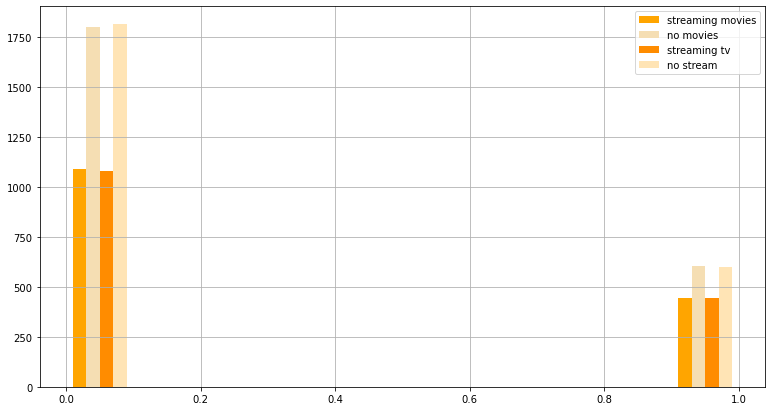

In [84]:
#comparison view
plt.figure(figsize = (13, 7))
plt.hist(
    [has_movies.churn, no_movies.churn, has_stream.churn, no_stream.churn],
    label = ['streaming movies', 'no movies', 'streaming tv', 'no stream'],
    color = ['orange', 'wheat', 'darkorange', 'moccasin']
)
plt.grid(True)
plt.legend();

#compare churn rates across streaming services
print(f'{round(has_movies.churn.mean() * 100)}% of customers with the streaming movie service churn.')
print(f'{round(no_movies.churn.mean() * 100)}% of customers without the streaming movie service churn.')
print(f'{round(has_stream.churn.mean() * 100)}% of customers with the streaming tv service churn.')
print(f'{round(no_stream.churn.mean() * 100)}% of customers without the streaming tv service churn.')

In [85]:
#confirm these are not the same
pd.crosstab(train.streaming_movies, train.streaming_tv)

streaming_tv,0,1
streaming_movies,,
0,1972,432
1,442,1091


#### Takeaways
* streaming tv and streaming movies are indeed separate services

* customers without the service seem to churn more by count, but proportianately less

### Question 7
Are customers with a certain subscription more likely to churn?

In [86]:
#assign variables to respective subscription data
no_phone_Fiber = train[(train.phone_service == 0) & (train.Fiber_internet == 1)]
no_phone_DSL = train[(train.phone_service == 0) & (train.DSL_internet == 1)]
one_line_no_internet = train[(train.phone_service == 1) & (train.multiple_lines == 0) & (train.no_internet == 1)]
one_line_Fiber = train[(train.phone_service == 1) & (train.multiple_lines == 0) & (train.Fiber_internet == 1)]
one_line_DSL = train[(train.phone_service == 1) & (train.multiple_lines == 0) & (train.DSL_internet == 1)]
multiple_lines_no_internet = train[(train.multiple_lines == 1) & (train.no_internet == 1)]
multiple_lines_Fiber = train[(train.multiple_lines == 1) & (train.Fiber_internet == 1)]
multiple_lines_DSL = train[(train.multiple_lines == 1) & (train.DSL_internet == 1)]

In [87]:
#no one has this subscription
no_phone_Fiber

,is_male,senior_citizen,partner,dependents,phone_service,paperless_billing,churn,tenure,monthly_charges,total_charges,...,two_year_contract,DSL_internet,Fiber_internet,no_internet,bank_auto_payment,card_auto_payment,electronic_check_payment,mailed_check_payment,high_charges,higher_than_average_charges
customer_id,,,,,,,,,,,,,,,,,,,,,


In [88]:
subscription_dfs = [no_phone_DSL, one_line_no_internet, one_line_Fiber, one_line_DSL, multiple_lines_no_internet, 
                 multiple_lines_Fiber, multiple_lines_DSL]

24% of customers with DSL internet and no phone churn.
9% of customers with one phone line and no internet churn.
45% of customers with one phone line and Fiber internet churn.
23% of customers with one phone line and DSL internet churn.
4% of customers with multiple lines and no internet churn.
39% of customers with multiple lines and Fiber internet churn.
10% of customers with multiple lines and DSL internet churn.


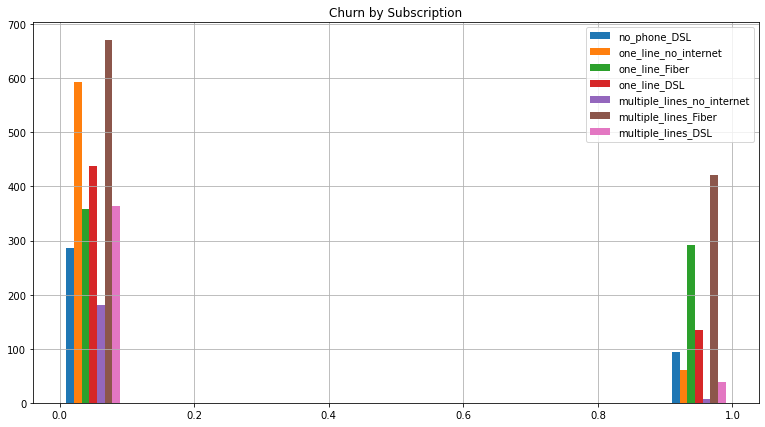

In [89]:
#show churn across subscriptions
plt.figure(figsize = (13, 7))
plt.title('Churn by Subscription')
plt.hist([no_phone_DSL.churn, one_line_no_internet.churn, one_line_Fiber.churn, one_line_DSL.churn,
          multiple_lines_no_internet.churn, multiple_lines_Fiber.churn, multiple_lines_DSL.churn],
         label = ['no_phone_DSL', 'one_line_no_internet', 'one_line_Fiber', 'one_line_DSL', 
           'multiple_lines_no_internet', 'multiple_lines_Fiber', 'multiple_lines_DSL']
        )
plt.grid(True)
plt.legend();

#for df in subscription_dfs:
    #print(f'{round(df.churn.mean() * 100)}%')
print(f'{round(no_phone_DSL.churn.mean() * 100)}% of customers with DSL internet and no phone churn.')
print(f'{round(one_line_no_internet.churn.mean() * 100)}% of customers with one phone line and no internet churn.')
print(f'{round(one_line_Fiber.churn.mean() * 100)}% of customers with one phone line and Fiber internet churn.')
print(f'{round(one_line_DSL.churn.mean() * 100)}% of customers with one phone line and DSL internet churn.')
print(f'{round(multiple_lines_no_internet.churn.mean() * 100)}% of customers with multiple lines and no internet churn.')
print(f'{round(multiple_lines_Fiber.churn.mean() * 100)}% of customers with multiple lines and Fiber internet churn.')
print(f'{round(multiple_lines_DSL.churn.mean() * 100)}% of customers with multiple lines and DSL internet churn.')

A lot of customers with Fiber internet seem to be churning.

In [90]:
#let's take a closer look at Fiber internet
Fiber = train[train.Fiber_internet == 1]
DSL = train[train.DSL_internet == 1]

In [91]:
#print churn rate for Fiber customers
print(f'{round(Fiber.churn.mean() * 100)}% of customers with Fiber internet churn.')

41% of customers with Fiber internet churn.


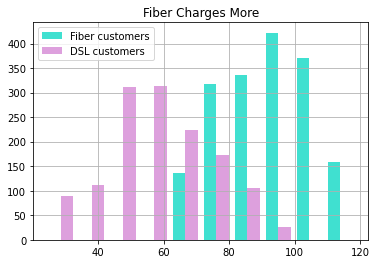

In [92]:
#how do Fiber monthly charges compare with DSL monthly charges?
plt.hist([Fiber.monthly_charges, DSL.monthly_charges],
         label = ['Fiber customers', 'DSL customers'],
         color = ['turquoise', 'plum']
        )
plt.grid(True)
plt.legend()
plt.title('Fiber Charges More');

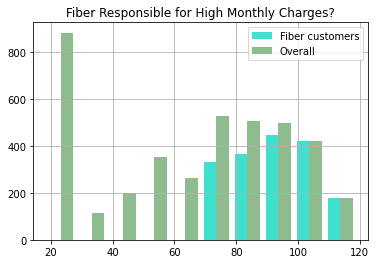

In [93]:
#how do Fiber monthly charges compare with overall monthly charges?
plt.hist([Fiber.monthly_charges, train.monthly_charges],
         label = ['Fiber customers', 'Overall'],
         color = ['turquoise', 'darkseagreen']
        )
plt.grid(True)
plt.legend()
plt.title('Fiber Responsible for High Monthly Charges?');

Are charges for Fiber customers higher than the average charges?

#### Null hypothesis: Fiber customers' charges are the same as or less than the average monthly charges.
#### Alternate hypothesis: Fiber customers' charges are more than the average monthly charges.

In [94]:
#how many observations do we have 
len(Fiber)
#distribution seems kinda normal, and we have an abundance of observations

1742

In [95]:
#Run a T-test to see if Fiber charges are higher than the overall mean of monthly charges
stats.ttest_1samp(Fiber.monthly_charges, train.monthly_charges.mean(), alternative = 'greater')

Ttest_1sampResult(statistic=86.04774907393157, pvalue=0.0)

#### Low p-value and positive t-value say I should reject the null hypothesis that Fiber customers' charges are the same or less as average monthly charges.

Is a Fiber subscription associated with churn?

27% of overall customers churn.
41% of customers with Fiber internet churn.


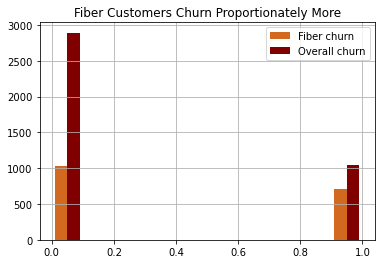

In [96]:
#let's compare churn
plt.hist([Fiber.churn, train.churn],
        label = ['Fiber churn', 'Overall churn'],
        color = ['chocolate', 'maroon']
        )
plt.title('Fiber Customers Churn Proportionately More')
plt.grid(True)
plt.legend();

print(f'{round(train.churn.mean() * 100)}% of overall customers churn.')
print(f'{round(Fiber.churn.mean() * 100)}% of customers with Fiber internet churn.')

#### Null hypothesis: Subscription to Fiber and churn are independent of each other.
#### Alternate hypothesis: Subscription to Fiber and churn are not independent of each other.

In [97]:
observed = pd.crosstab(train.Fiber_internet, train.churn)
observed

churn,0,1
Fiber_internet,,
0,1862,333
1,1029,713


In [98]:
#results
chi2, p, degf, expected = stats.chi2_contingency(observed)
print('Observed')
print('--------')
print(observed.values)
print('===================')
print('Expected')
print('--------')
print(expected.astype(int))
print('===================')
print(f'Degrees of Freedom: {degf}')
print('===================')
print('Chi^2 and P')
print('-----------')
print(f'chi^2 = {chi2:.4f}')
print(f'p = {p:.4f}')

Observed
--------
[[1862  333]
 [1029  713]]
Expected
--------
[[1611  583]
 [1279  462]]
Degrees of Freedom: 1
Chi^2 and P
-----------
chi^2 = 328.9976
p = 0.0000


#### Extremely low p-value allows me to reject the null hypothesis that a fiber subscription and churn are independent of each other.

#### Takeaways
* having a fiber subscription and churn are associated

* customers with a fiber subscription are charged significantly more than the average customer

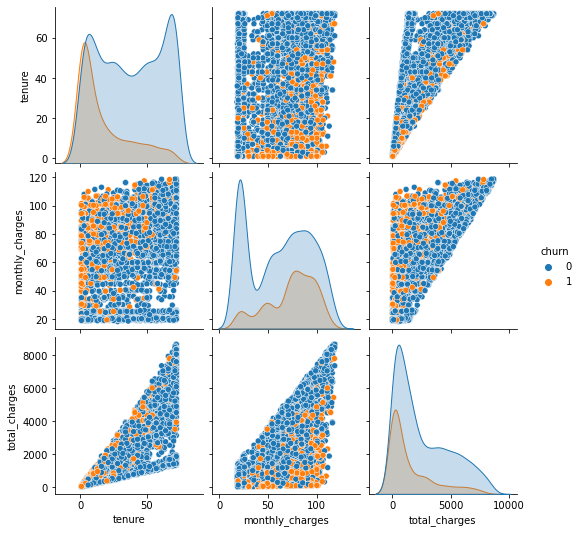

In [99]:
#how do continuous variables interact with each other and the target?
sns.pairplot(train, vars = quant_vars, hue = 'churn')
plt.show();

#### Takeaways
* lots of churn for customers with high monthly charges early in the tenure

In [100]:
#what correlates with churn?
heat_map = pd.DataFrame(train.corr()['churn'])
heat_map.sort_values(by = 'churn', ascending = False)

,churn
churn,1.000000
m2m_contract,0.404579
Fiber_internet,0.289656
electronic_check_payment,0.279599
paperless_billing,0.195112
higher_than_average_charges,0.190416
monthly_charges,0.171508
senior_citizen,0.149055
high_charges,0.053628
streaming_tv,0.047658


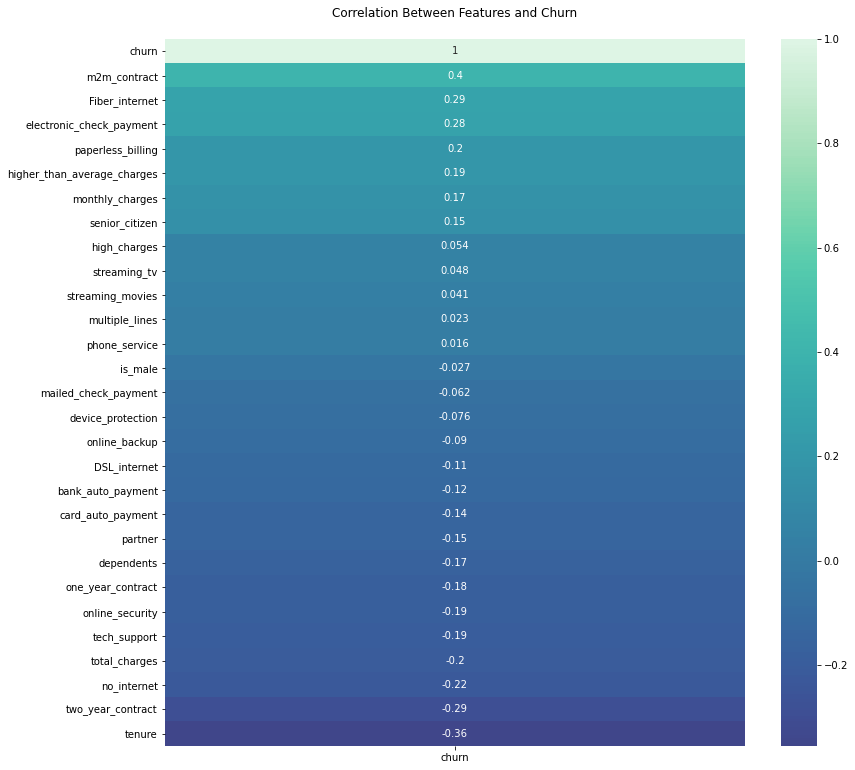

In [101]:
#viz
plt.figure(figsize = (13, 13))
plt.title('Correlation Between Features and Churn', pad = 22)
sns.heatmap(heat_map.sort_values(by = 'churn', ascending = False), cmap = 'mako', center = 0, annot = True)
plt.show();

#### Takeaways
* m2m_contract, tenure, Fiber_internet, two_year_contract, and electronic_check_payment have the strongest correlation with churn
* Month-to-month contracts, Fiber subscriptions and the electronic check payment method positively correlate the most with churn
* Tenure and 2-year contracts negatively correlate the most with churn

## Exploration Takeaways


Viz Takeaways

* over a quarter of customers are churning

* customers on the month-to-month contract churn far more than customers on other contracts

* churn rate for male customers and female customers seem the same

* customers without dependents seem to churn more than those without

* customers without a partner seem to churn much more

* m2m_contract, tenure, Fiber_internet, two_year_contract, and electronic_check_payment have the strongest correlation with churn

* Month-to-month contracts, Fiber subscriptions and the electronic check payment method positively correlate the most with churn

* Tenure and 2-year contracts negatively correlate the most with churn

* lots of churn for customers with high monthly charges early in the tenure

Stats Tests Takeaways

* customers who churn are charged significantly more than those who do not

* higher charges are associated with churn

* having a fiber subscription and churn are associated

* customers with a fiber subscription are charged significantly more than the average customer

Moving Forward
* I will move forward with the higher charges features because the chi2 statistic seems too strong to ignore

* I will move forward with the fiber subscription feature because customers with fiber have higher charges and churn and fiber internet are associated here